In [1]:
import sys 
import os 

nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from plotlib.loaders import *
from plotlib.plotters import *
from phdconf.config import *
from phdconf import config 
# from plotlib.plotters import *

plt.style.use('seaborn-white')

%matplotlib inline

In [2]:
queries = load_queries(AUS_TOPIC_PATH)
broad, specific = load_query_types(queries)

In [3]:
# index_names = [config.AUS_INDEX_NAME, 'filtered-stop']#, config.SIGIR_INDEX_NAME]
index_names = ['filtered-phrasestop']
qrel_paths = [config.AUS_QREL_PATH, config.AUS_QREL_PATH]#, config.SIGIR_QREL_PATH]
rel_levels = [config.AUS_REL_LEVEL, config.AUS_REL_LEVEL]#, config.SIGIR_REL_LEVEL]
display_names = ['AUS', 'FIL_STOP']#, 'SIGIR']

In [4]:
BASE_DIR = os.path.join(os.environ["HOME"], 'phd-generated')

In [5]:
mu = 2000
base_df = load_1d_dfs(['filtered-phrasestop'], qrel_paths, os.path.join(BASE_DIR, 'preprocessing', 'dirichlet_prior'), 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, mu, mu, 1)[0][0]
base_qry = load_1d_dfs(['filtered-phrasestop'], qrel_paths, os.path.join(BASE_DIR, 'preprocessing', 'dirichlet_prior'), 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, mu, mu, 1, per_query=True)[0][0]

In [71]:
jm_path = os.path.join(BASE_DIR, 'jelinek_mercer')

lambda_start = 0.0
lambda_end = 1.0
increment = 0.05

In [72]:
jm_dfs = load_1d_dfs(index_names, qrel_paths, jm_path, 'case-topics-{0}-unigram_jm_lambda_{1:.2f}.run', rel_levels, lambda_start, lambda_end, increment)

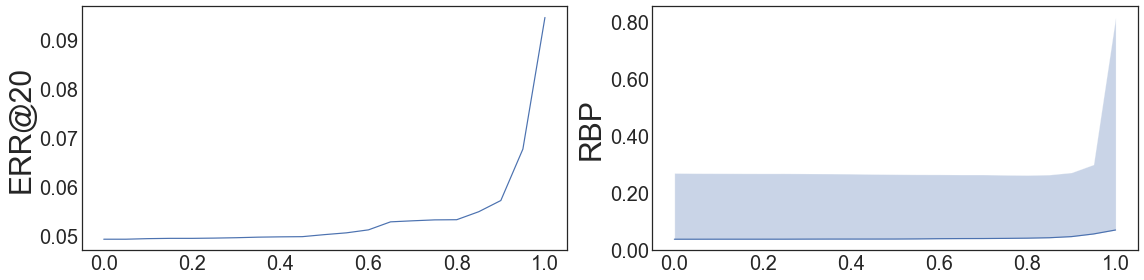

In [73]:
jm_fig = plot_single_orientation([''], RERANK_METRICS, jm_dfs, lambda_start, lambda_end, increment)
jm_fig.savefig('figures/jm-tune.pdf')

## Dirichlet Prior 

In [74]:
dir_path = os.path.join(BASE_DIR, 'preprocessing', 'dirichlet_prior')

mu_start = 300.0
mu_end = 3000.0
mu_increment = 50.0

In [75]:
dir_dfs = load_1d_dfs(index_names, qrel_paths, dir_path, 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, mu_start, mu_end, mu_increment)

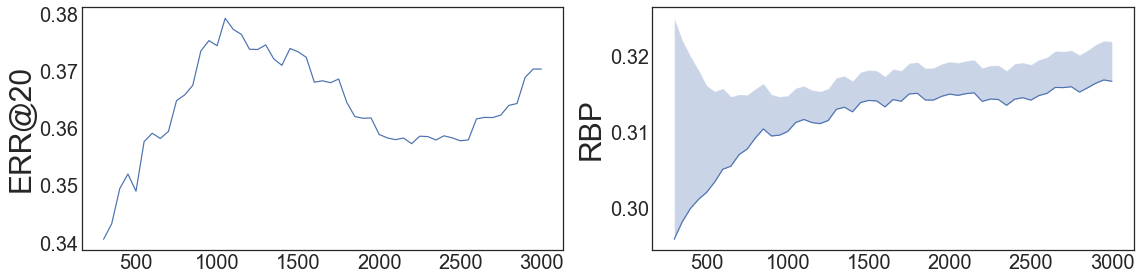

In [76]:
dir_fig = plot_single_orientation(['ausnl'], RERANK_METRICS, dir_dfs, mu_start, mu_end, mu_increment)
dir_fig.savefig('figures/dir-tune.pdf')

# Max unused

In [19]:
# jm_max = select_1d_max(display_names, metric_names, jm_dfs, lambda_start, increment, "$\lambda$", metric_names)
# print(jm_max.to_latex(float_format="{:0.4f}".format, escape=False))

In [20]:
# jm_bs_max = select_1d_max(['Broad', 'Specific'], metric_names, [jm_broad_dfs[0], jm_specific_dfs[0]], lambda_start, increment, "$\lambda$", metric_names)
# print(jm_bs_max.to_latex(float_format="{:0.4f}".format, escape=False))

In [21]:
#dir_max = select_1d_max(['aus'], config.METRIC_NAMES, dir_dfs, 1000, mu_increment, "$\mu$", config.METRIC_NAMES)
#print(dir_max.to_latex(float_format="{:0.4f}".format, escape=False))

In [22]:
#dir_bs_max = select_1d_max(['Broad', 'Specific'], config.METRIC_NAMES, [dir_b_dfs[0], dir_s_dfs[0]], 300, mu_increment, "$\mu$", config.METRIC_NAMES)
#print(dir_bs_max.to_latex(float_format="{:0.4f}".format, escape=False))

In [23]:
bm25_path = 'bm25'

def load_bm25_dfs(index_names, qrel_paths, results_path, rel_levels, name='{0}-filtered-phrasestop-unigram_bm25_k1_{1:.2f}_b_{2:.2f}.run', per_query=False, filtered=None):
    k1_start = 1.2
    k1_end = 3.05
    b_start = 0.05
    b_end = 1.05
    increment = 0.05
    
    dfs = []
    
    for i in range(len(index_names)):
        dfs.append([])
        cnt = 0
        for k1 in np.arange(k1_start, k1_end, increment):
            dfs[i].append([])
            for b in np.arange(b_start, b_end, increment):
                dfs[i][cnt].append(to_trec_df(qrel_paths[i], os.path.join(results_path, name.format(index_names[i], k1, b)), rel_levels[i], per_query=per_query, filtered=filtered))
            cnt+=1
    
    return dfs 

In [24]:
bm25_dfs = load_bm25_dfs(['case-topics'], qrel_paths, os.path.join(BASE_DIR, bm25_path), rel_levels)

In [25]:
tt_folds = read_folds('ausnl-folds.txt')

In [26]:
jm_qry_dfs = load_1d_dfs(index_names, qrel_paths, jm_path, 'case-topics-{0}-unigram_jm_lambda_{1:.2f}.run', rel_levels, lambda_start, lambda_end, increment, per_query=True)
dir_qry_dfs = load_1d_dfs(index_names, qrel_paths, dir_path, 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, mu_start, mu_end, mu_increment, per_query=True)
tf_df = load_1d_dfs(index_names, qrel_paths, os.path.join(BASE_DIR, 'tfidf'), 'case-topics-filtered-phrasestop-unigram_tfidf.run', rel_levels, 1, 1, 1, per_query=True)
tfln_df = load_1d_dfs(index_names, qrel_paths, os.path.join(BASE_DIR, 'tfidf'), 'case-topics-filtered-phrasestop-unigram_tfidfln.run', rel_levels, 1, 1, 1, per_query=True)

In [27]:
bm25_query_dfs = load_bm25_dfs(['case-topics'], qrel_paths, os.path.join(BASE_DIR, bm25_path), rel_levels, per_query=True)

In [28]:
len(jm_qry_dfs[0])

21

In [41]:
cv_df = pd.DataFrame(columns=config.METRIC_NAMES)

for ab, runs in zip(['JM', 'DP', 'BM25', 'TFIDF', 'TFIDF\subscript{norm}'], [jm_qry_dfs[0], dir_qry_dfs[0], list(chain.from_iterable(bm25_query_dfs[0])), tf_df[0], tfln_df[0]]):
    cross = cross_validation(runs, tt_folds, config.METRIC_NAMES, base_qry)
    cv_df.loc[ab] = cross[0]

TypeError: 'NoneType' object is not subscriptable

In [30]:
write_table('tables/ausnl-traditional', bold_max(cv_df).drop('unjudged@20',axis='columns').rename(config.METRIC_NAMES, axis='columns').to_latex(escape=False))

In [31]:
# same but for sigir
jm_qry_dfs = load_1d_dfs(['sigir-stop'], sig_qrels, jm_path, 'sigir-topic-topics-{0}-unigram_jm_lambda_{1:.2f}.run', rel_levels, lambda_start, lambda_end, increment, per_query=True, filtered=[1, 3, 9, 19, 23, 25, 31, 37, 39, 45, 51, 97])
dir_qry_dfs = load_1d_dfs(['sigir-stop'], sig_qrels, os.path.join(BASE_DIR, 'dirichlet_prior'), 'sigir-topic-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, mu_start, mu_end, mu_increment, per_query=True, filtered=[1, 3, 9, 19, 23, 25, 31, 37, 39, 45, 51, 97])
tf_df = load_1d_dfs(['sigir-stop'], sig_qrels, os.path.join(BASE_DIR, 'tfidf'), 'sigir-topic-topics-sigir-stop-unigram_tfidf.run', rel_levels, 1, 1, 1, per_query=True, filtered=[1, 3, 9, 19, 23, 25, 31, 37, 39, 45, 51, 97])
tfln_df = load_1d_dfs(['sigir-stop'], sig_qrels, os.path.join(BASE_DIR, 'tfidf'), 'sigir-topic-topics-sigir-stop-unigram_tfidfln.run', rel_levels, 1, 1, 1, per_query=True, filtered=[1, 3, 9, 19, 23, 25, 31, 37, 39, 45, 51, 97])

In [32]:
bm25_query_dfs = load_bm25_dfs(['sigir-topic-topics'], sig_qrels, os.path.join(BASE_DIR, bm25_path), rel_levels, name='{0}-sigir-stop-unigram_bm25_k1_{1:.2f}_b_{2:.2f}.run', per_query=True, filtered=[1, 3, 9, 19, 23, 25, 31, 37, 39, 45, 51, 97])

In [33]:
base_sig = load_1d_dfs(['sigir-stop'], sig_qrels, os.path.join(BASE_DIR, 'dirichlet_prior'), 'sigir-topic-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, 1500, 1500, 1, per_query=True, filtered=[1, 3, 9, 19, 23, 25, 31, 37, 39, 45, 51, 97])[0][0]

#sig_folds = [[[1, 3, 9, 19, 23, 25, 31, 37, 39, 45, 51, 97], [1, 3, 9, 19, 23, 25, 31, 37, 39, 45, 51, 97]]]
sig_folds = read_folds('sigir-folds.txt')

In [34]:
cv_df = pd.DataFrame(columns=config.METRIC_NAMES)
for ab, runs in zip(['JM', 'DP', 'BM25', 'TFIDF', 'TFIDF\subscript{norm}'], [jm_qry_dfs[0], dir_qry_dfs[0], list(chain.from_iterable(bm25_query_dfs[0])), tf_df[0], tfln_df[0]]):
    cross = cross_validation(runs, sig_folds, config.METRIC_NAMES, base_sig)
    cv_df.loc[ab] = cross[0]
    
write_table('tables/sigir-traditional', bold_max(cv_df).drop('unjudged@20',axis='columns').rename(config.METRIC_NAMES, axis='columns').to_latex(escape=False))

In [35]:
jm_qry_dfs = None
dir_qry_dfs = None
bm25_qry_dfs = None

In [36]:
# get max run 

def create_max_df(bm25_dfs): 
    k1_start = 1.2
    k1_end = 3.05
    b_start = 0.05
    b_end = 1.05
    increment = 0.05
    
    num_x = len(bm25_dfs[0][0])
    num_y = len(bm25_dfs[0])
    
    x = np.array([[i]*num_x for i in np.arange(k1_start, k1_end, increment)])
    y = np.array([list(np.arange(b_start, b_end, increment))] * num_y)
    
    max_for = {}
    for i in range(len(bm25_dfs)):
        for j in range(len(bm25_dfs[i])):
            inds = bm25_dfs[i][j].index
            for ind in inds:
                if ind not in max_for:
                    max_for[ind] = (bm25_dfs[i][j][ind], i, j)
                else:
                    if bm25_dfs[i][j][ind] > max_for[ind][0]:
                        max_for[ind] = (bm25_dfs[i][j][ind], i, j)
              
    for measure in max_for:
        max_for[measure] = {'b': y[0][max_for[measure][2]], 'k1': x[max_for[measure][1]][0], 'score': max_for[measure][0]}
        
    max_df = pd.DataFrame.from_dict(max_for, orient='index')
    return max_df

In [37]:
bm25_max_df = create_max_df(bm25_dfs[0])

In [38]:
bm25_max_df

,b,k1,score
recip_rank,0.75,1.45,0.579520
unjudged@20,0.05,1.20,6.642105
recall_20,0.30,2.95,0.471794
recall_100,0.55,1.90,0.712279
ndcg,0.50,2.65,0.462709
set_P,0.55,2.50,0.078211
set_recall,0.55,1.90,0.712279
set_F_.5,0.55,2.50,0.105228
rbp@0.10,0.45,1.20,0.484116
rbp-res@0.10,0.05,1.20,0.048638


In [39]:
print(bm25_max_df[bm25_max_df.index.isin(config.METRIC_NAMES)].rename(index=config.METRIC_NAMES).round(4).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &     b &    k1 &   score \\
\midrule
RR          &  0.75 &  1.45 &  0.5795 \\
Unjudged@20 &  0.05 &  1.20 &  6.6421 \\
R@20        &  0.30 &  2.95 &  0.4718 \\
R@100       &  0.55 &  1.90 &  0.7123 \\
NDCG        &  0.50 &  2.65 &  0.4627 \\
RBP         &  0.50 &  2.70 &  0.3202 \\
ERR@20      &  0.50 &  2.90 &  0.3724 \\
\bottomrule
\end{tabular}



In [40]:
def plot_bm25(metric_names, dfs, ylims=[]): 
    r = int(len(metric_names)/2)
    c = r
    if c == r: 
        r-=1
    if len(metric_names)%2 != 0:
        c += 1 
    
    fig, axs = plt.subplots(r, c, subplot_kw=dict(projection='3d'))
    fig.set_size_inches(16, 8)
    
    k1_start = 1.2
    k1_end = 3.05
    b_start = 0.05
    b_end = 1.05
    increment = 0.05
    
    num_x = len(dfs[0])
    num_y = len(dfs)
    
    x = np.array([[i]*num_x for i in np.arange(k1_start, k1_end, increment)])
    y = np.array([list(np.arange(b_start, b_end, increment))] * num_y)
            
    cnt = 0 
    row = 0
    for m in metric_names:

        z = [[y[m] for y in x] for x in dfs]
        z = np.array(z)

        axs[row, cnt].plot_surface(x, y, z, cmap=cm.gray)

        axs[row, cnt].tick_params(labelsize=10)
        axs[row, cnt].zaxis.set_major_formatter(FormatStrFormatter('%.3f'))

        print(row, cnt, m)
        axs[row, cnt].set_zlabel(metric_names[m], fontsize=14, rotation='vertical')
        
#         axs[row, cnt].view_init(30,20)

        cnt += 1 
        if cnt >= c:
            cnt = 0
            row += 1
                
    if len(metric_names) % 2 != 0: 
        fig.delaxes(axs[row, -1])
        
#     for i in range(len(ylims)):
#         plt.gcf().get_axes()[i].set_ylim(ymax=ylims[i])
                
#     fig.subplots_adjust(wspace=0.07, hspace=0.05, left=0.01, right=1.7)
    return fig 

bm25_fig = plot_bm25({'rbp@0.80':'RBP'}, bm25_dfs[0], ylims=all_ylims)

ValueError: negative dimensions are not allowed

<Figure size 1152x720 with 0 Axes>

In [ ]:
bm25_fig.savefig('figures/ausnl-bm25-tune.pdf')

In [42]:
def plot_single_bm25(dfs, metric):
    fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection='3d'))
    fig.set_size_inches(16, 8)
    
    k1_start = 1.2
    k1_end = 3.05
    b_start = 0.05
    b_end = 1.05
    increment = 0.05
    
    num_x = len(dfs[0])
    num_y = len(dfs)
    
    x = np.array([[i]*num_x for i in np.arange(k1_start, k1_end, increment)])
    y = np.array([list(np.arange(b_start, b_end, increment))] * num_y)
    
    z = [[y[list(metric.keys())[0]] for y in x] for x in dfs]
    z = np.array(z)
    
    axs.plot_surface(x, y, z, cmap=cm.gray)

    axs.tick_params(axis='x',labelsize=25, pad=3)
    axs.tick_params(axis='y',labelsize=25, pad=3)
    axs.tick_params(axis='z',labelsize=25, pad=13)
    axs.set_ylabel('b', fontsize=35, rotation='horizontal', labelpad=25)
    axs.set_xlabel('k1', fontsize=35, rotation='horizontal', labelpad=25)
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    axs.set_zlabel(list(metric.values())[0], fontsize=30, rotation='vertical', labelpad=27)
    
    return fig

bm25_fig = plot_single_bm25(bm25_dfs[0], {'rbp@0.80': 'RBP'})
bm25_fig.savefig('figures/ausnl-bm25-tune.pdf')

<Figure size 1152x576 with 1 Axes>

In [43]:
bm25_dfs = load_bm25_dfs(['sigir-topic-topics'], [config.SIGIR_QREL_PATH], 
    os.path.join(BASE_DIR, bm25_path), name='{0}-sigir-stop-unigram_bm25_k1_{1:.2f}_b_{2:.2f}.run', 
    rel_levels=[config.SIGIR_REL_LEVEL])

In [44]:
bm25_fig = plot_single_bm25(bm25_dfs[0], {'rbp@0.80': 'RBP'})
bm25_fig.savefig('figures/sigir-bm25-tune.pdf')

<Figure size 1152x576 with 1 Axes>

In [45]:
def all_combinations(n, k, increment: float):
    ret = []
    cnt = 0
    inp = [0] * (k + 1)
    inc = int(increment * 100)
    mtc = False 
    t = n
    h = 0
    while True:
        if mtc:
            if t > 1:
                h = 0
            h+=1
            t = inp[h]
            inp[h] = 0
            inp[1] = t - 1
            inp[h + 1]+=1
        else:
            inp[1] = n
            for i in range(2, k+1):
                inp[i] = 0
        
        allVal = True
        for i in range(1, k+1):
            if inp[i] == n:
                break
            
            if inp[i] % inc != 0:
                allVal = False
                break
        
        if allVal:
            add = []
            for i in range(1, k+1):
                add.append(float(inp[i]) / 100.0)
            
            ret.append(add)
            cnt+=1
        

        mtc = inp[k] != n
        if not mtc:
            break
    
    return ret


    

In [6]:
sdm_measures = []
smooth_measures = []
metric_names = ['ERR', 'RBP']
for m in metric_names:
    sdm_measures.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', [os.path.join('/home/danlocke/go/src/gridsearch', 'sdm-'+str(x)+"-window-"+m+"-combine-max.run") for x in range(1, 21)]))
    smooth_measures.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', [os.path.join('/home/danlocke/go/src/gridsearch', 'sdm-'+str(x)+"-smooth-window-"+m+"-combine-max.run") for x in range(1, 21)]))

In [7]:
def plot_different(dfs, smooth_dfs, base, metric_names, start, end, increment, names=[], styles=[], y_lims=[], legend_x=0.96, legend_y=0.46):
    if len(metric_names) == 2:
        r = 1
        c = 2
    else:
        r = int(len(metric_names)/2)
        c = r
        if len(metric_names)%2 != 0:
            c += 1 
        
    fig, axs = plt.subplots(r, c)
    fig.set_size_inches(16, 4)
    x = np.arange(start, end+increment, increment)
    cnt = 0 
    row = 0
    for i, (df, smooth_df, m) in enumerate(zip(dfs, smooth_dfs, metric_names)):
        s = None 
        if i < len(styles): 
            s = styles[i]

        axs[cnt].plot(x, [base[m] for x in range(len(df))], linestyle=s)
        axs[cnt].plot(x, [y[m] for y in df], linestyle=s)
        axs[cnt].plot(x, [y[m] for y in smooth_df], linestyle=s)
        if m.startswith('rbp@'):
            es = 'rbp-res@'+m[4:]
            axs[cnt].fill_between(x, [base[m] for y in range(len(df))], [base[es]+base[m] for y in range(len(df))], alpha=0.3)
            axs[cnt].fill_between(x, [y[m] for y in df], [y[es]+y[m] for y in df], alpha=0.3)
            axs[cnt].fill_between(x, [y[m] for y in smooth_df], [y[es]+y[m] for y in smooth_df], alpha=0.3)

        axs[cnt].set_ylabel(metric_names[m],fontsize=30)
        axs[cnt].tick_params(labelsize=15)
        axs[cnt].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cnt += 1 
    
    for i in range(len(y_lims)):
        plt.gcf().get_axes()[i].set_ylim(ymax=y_lims[i])
    
    if len(metric_names) % 2 != 0: 
        fig.delaxes(axs[row, -1])

    if len(names) > 0:
        fig.legend(names, bbox_to_anchor=[legend_x, legend_y], frameon=True, ncol=2, prop={"size": 15}).get_frame().set_edgecolor('black')
        
    fig.tight_layout()
    return fig
    

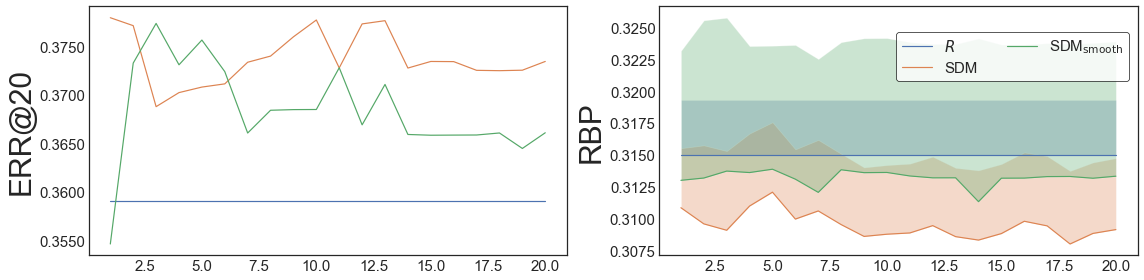

In [8]:
sdm_max_fig = plot_different(sdm_measures, smooth_measures, base_df, RERANK_METRICS, 1, 20, 1, names=['$R$', 'SDM', 'SDM$_{\mathrm{smooth}}$'], legend_y=0.9, legend_x=0.99)
sdm_max_fig.savefig('figures/sdm-window.pdf')

In [19]:
sdm_index = ['filtered-phrasestop']#, 'sigir']
sdm_path = 'sdm_rerank'
sdm_dir_mu = [1050]#, 1350]

def load_sdm(index_names, qrel_paths, str_format, results_path, sdm_dir_mu, increment, window, per_query=False, clip=True):
    dfs = []
    combs = all_combinations(100, 3, increment)
    for i, ind in enumerate(index_names):
        temp = []
        for comb in combs:
            if clip and comb[0] > 0.6 or not clip:
                temp.append((comb, to_trec_df(qrel_paths[i], 
                  os.path.join(results_path, str_format.format(ind, sdm_dir_mu[i], comb[0], comb[1], comb[2], window)), rel_levels[i], per_query=per_query)))
        
        dfs.append(temp)
    
    return dfs 

# sdm_format = '{0}-sdm-dir-mu-{1:.2f}-weights-{2:.2f}-{3:.2f}-{4:.2f}-window-{5}.run'

# sdm_dfs = load_sdm(sdm_index, [config.AUS_QREL_PATH], 'case-topics-{0}-sdm_rerank-dir-mu-{1:.2f}-weights-{2:.2f}-{3:.2f}-{4:.2f}-window-{5}.run', os.path.join(BASE_DIR, sdm_path), sdm_dir_mu, 0.05, 11)

In [55]:
mu = 1050
base_df = load_1d_dfs(['filtered-phrasestop'], qrel_paths, os.path.join(BASE_DIR, 'preprocessing', 'dirichlet_prior'), 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, mu, mu, 1)[0][0]
base_qry = load_1d_dfs(['filtered-phrasestop'], qrel_paths, os.path.join(BASE_DIR, 'preprocessing', 'dirichlet_prior'), 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, mu, mu, 1, per_query=True)[0][0]

In [56]:
sdm_measures = []
smooth_measures = []
for m in metric_names:
    sdm_measures.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', [os.path.join('/home/danlocke/go/src/gridsearch', 'sdm-'+str(x)+"-window-"+m+"-combine-max.run") for x in range(1, 21)], per_query=True))
    smooth_measures.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', [os.path.join('/home/danlocke/go/src/gridsearch', 'sdm-'+str(x)+"-smooth-window-"+m+"-combine-max.run") for x in range(1, 21)], per_query=True))

In [57]:
def max_runs_per_metric(runs, metrics, base_qry):
    _max = [0.0] * len(metrics)
    max_inds = [0] * len(metrics)
    print(len(runs), len(metrics))
    
    for i, (metric_runs, m) in enumerate(zip(runs, metrics)):
        for j, run in enumerate(metric_runs):            
            v = run[m].mean()
            if v > _max[i]:
                _max[i] = v
                max_inds[i] = j

    for i, m in enumerate(metrics):
        p = stats.ttest_rel(runs[i][max_inds[i]][m], base_qry[m]).pvalue
        mean = base_qry[m].mean()
        if p < 0.01:
            _max[i] = '{0:.4f}'.format((_max[i])) + "$^{**}$"
        elif p < 0.05: 
            _max[i] = '{0:.4f}'.format((_max[i])) + "$^{*}$"
        else:
            _max[i] = '{0:.4f}'.format((_max[i]))

    return _max, max_inds

cv_df = pd.DataFrame(columns=om)

for ab, runs in zip(['SDM', 'SDM\subscript{smooth}'], [sdm_measures, smooth_measures]):
    cross = max_runs_per_metric(runs, om, base_qry)
    cv_df.loc[ab] = cross[0]

5 5
5 5


In [58]:
# insert plm into df
def load_plm(ind, qrel_path, str_format, results_path, rel_level, per_query=False):
    dfs = []
    # sigma
    for s in range(10, 510, 10):
        temp = []
        for mu in range(300, 2050, 50):
            temp.append((s, mu, to_trec_df(qrel_path, 
              os.path.join(results_path, str_format.format(ind, mu, s)), rel_level, per_query=per_query)))        
        dfs.append(temp)
    
    return dfs 

plm_qry_dfs = load_plm(index_names[0], qrel_paths[0], 'case-topics-{0}-plm-dir-mu-{1:.2f}-sigma-{2:.2f}.run', os.path.join(BASE_DIR, 'plm'), '1', per_query=True)
flattened = [x[2] for y in plm_qry_dfs for x in y]

In [59]:
for ab, runs in zip(['PLM'], [flattened]):
    cross = cross_validation(runs, tt_folds, om, base_qry)
    cv_df.loc[ab] = cross[0]

In [60]:
cv_df.loc['$R$'] = ['{:.4f}'.format(base_df[m]) for m in om]
cv_df = cv_df.reindex(['$R$', 'PLM', 'SDM', 'SDM\subscript{smooth}'])
write_table('tables/ausnl-bbow', bold_max(cv_df).rename(config.METRIC_NAMES, axis='columns').to_latex(escape=False))

In [64]:
def plot_qry_diff(runs, qry_df, metrics):
    _max = [0.0] * len(metrics)
    max_inds = [0] * len(metrics)
    print(len(runs), len(metrics))
    qry_res = pd.DataFrame()
    
    for i, (metric_runs, m) in enumerate(zip(runs, metrics)):
        for j, run in enumerate(metric_runs):            
            v = run[m].mean()
            if v > _max[i]:
                _max[i] = v
                max_inds[i] = j

    for i, m in enumerate(metrics):
        qry_res[m] = runs[i][max_inds[i]][m]
                        
    qry_res.sort_index(inplace=True)
    qry_comp_df = qry_res-qry_df
    qry_comp_fig = qry_comp_df[metrics.keys()].rename(metrics, axis='columns').plot.box(fontsize=15, boxprops=dict(linestyle='-', linewidth=2), medianprops=dict(linestyle='-', linewidth=2), color=dict(boxes='black', whiskers='black', medians='b', caps='r'),figsize=(16, 4)).axhline(y=0, xmin=0.0, xmax=1.0, linestyle='--', linewidth=1.0, color='grey')
    return qry_comp_fig

metrics = copy.copy(config.METRIC_NAMES)
del metrics['unjudged@20']
sdm_qry_diff = plot_qry_diff(smooth_measures, base_qry, om)
sdm_qry_diff.get_figure().savefig('figures/ausnl-sdm-qry-diff.pdf')

5 5


<Figure size 1152x288 with 1 Axes>

In [65]:
qry_comp_df = all_sdm_smooth[0][0][0][1].sort_index()-base_qry
qry_comp_fig = qry_comp_df[metrics.keys()].rename(metrics, axis='columns').plot.box(fontsize=15, boxprops=dict(linestyle='-', linewidth=2), medianprops=dict(linestyle='-', linewidth=2), color=dict(boxes='black', whiskers='black', medians='b', caps='r'),figsize=(16, 4)).axhline(y=0, xmin=0.0, xmax=1.0, linestyle='--', linewidth=1.0, color='grey')

NameError: name 'all_sdm_smooth' is not defined

In [60]:
all_folds = [y for x in range(0, 4) for y in tt_folds[x][0]]
print(len(all_sdm_smooth[0][0][0][1][all_sdm_smooth[0][0][0][1].index.isin(all_folds)].append(all_sdm_smooth[0][0][33][1][all_sdm_smooth[0][0][33][1].index.isin(tt_folds[4][0])])))

NameError: name 'all_sdm_smooth' is not defined

In [30]:
all_sdm = None
all_sdm_smooth = None

In [61]:
sdm_dfs = load_sdm(sdm_index, [config.AUS_QREL_PATH], 'case-topics-{0}-sdm_rerank-smooth-dir-mu-{1:.2f}-weights-{2:.2f}-{3:.2f}-{4:.2f}-window-{5}.run', os.path.join(BASE_DIR, sdm_path), sdm_dir_mu, 0.05, 8, clip=False)

NameError: name 'all_combinations' is not defined

In [117]:
from matplotlib.collections import PolyCollection

def plot_sdm_1d(dfs, index_names, metric_names):
    r = int(len(metric_names)/2)
    c = r
    r -= 1
#     if len(metric_names)%2 != 0:
#         c += 1 
    
    fig, axs = plt.subplots(r, c, subplot_kw=dict(projection='3d'))
    fig.set_size_inches(16, 8)
    
    xs = np.array([x[0][0] for x in dfs])
    ys = np.array([x[0][1] for x in dfs])

    verts = list(zip(xs, ys))
    cnt = 0 
    row = 0 
    print(r, c)
    print(xs.shape, ys.shape)
    for m in metric_names:
        print(row, cnt)
        zs = np.array([x[1][m] for x in dfs])
#         print(zs.shape)
#                 print(sorted(list(zip(zs, verts))))

        axs[row, cnt].scatter(xs, ys, zs)

        axs[row, cnt].tick_params(labelsize=10)
        axs[row, cnt].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs[row, cnt].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs[row, cnt].zaxis.set_major_formatter(FormatStrFormatter('%.4f'))

        axs[row, cnt].set_zlabel(metric_names[m],fontsize=20, rotation=90)

        axs[row, cnt].view_init(20, 120)
        cnt += 1 
        if cnt >= c: 
            cnt = 0 
            row += 1 
            
    if len(metric_names) % 2 != 0: 
        fig.delaxes(axs[row, -1])
                
#     fig.subplots_adjust(wspace=0.07, hspace=0.05, left=0.01, right=1.7)

    fig.tight_layout()
    return fig 

# def plot_sdm(dfs, index_names, metric_names):
    
#     fig, axs = plt.subplots(len(metric_names), len(index_names), subplot_kw=dict(projection='3d'))
#     fig.set_size_inches(16, 8)
#     xs = np.array([x[0][0] for x in dfs])
#     ys = np.array([x[0][1] for x in dfs])

#     verts = list(zip(xs, ys))
#     cnt = 0 
#     for j, m in enumerate(dfs[i][0][1].index):
#         if m in metric_names:
#             zs = np.array([x[1][m] for x in dfs])
# #                 print(sorted(list(zip(zs, verts))))

#             axs[cnt, i].scatter(xs, ys, zs)

#             axs[cnt, i].tick_params(labelsize=10)
#             axs[cnt, i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#             axs[cnt, i].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#             axs[cnt, i].zaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#             if i == 0:
#                 axs[cnt, i].set_zlabel(metric_names[m],fontsize=20)

#             axs[cnt, i].view_init(30, 120)
#             cnt += 1 
            
#     fig.tight_layout()

rerank_metrics = copy.copy(config.METRIC_NAMES)
del rerank_metrics['recall_100']
    
sdm_fig = plot_sdm_1d(sdm_dfs[0], display_names[0], rerank_metrics)
# sdm_fig.savefig('figures/aus-sdm-tune.pdf')

2 3
(231,) (231,)
0 0
0 1
0 2
1 0
1 1
1 2


<Figure size 1152x576 with 6 Axes>

In [17]:
def get_max_sdm_values(index, qrel_paths, sdm_format, sdm_path, mu, inc, window_range, metrics):
    m = {} 

    for i in window_range:
        df = load_sdm(index, qrel_paths, sdm_format, os.path.join(BASE_DIR, sdm_path), mu, inc, i)
        for d in df[0]:
            for v in d[1].index:
                if v in metrics: 
                    if (i, metrics[v]) not in m: 
                        m[(i, metrics[v])] = {'-': d[1][v], 'weights': d[0]}
                    elif d[1][v] > m[(i, metrics[v])]['-']:
                        m[(i, metrics[v])] = {'-': d[1][v], 'weights': d[0]}
    max_df = pd.DataFrame.from_dict(m).stack().unstack(level=0)
    return max_df.reindex(list(metrics.values()))

max_sdm = get_max_sdm_values(sdm_index, qrel_paths, sdm_format, sdm_path, sdm_dir_mu, 0.1, range(1, 3), metric_names)

In [19]:

print(max_sdm.to_latex(**latex_args))

\begin{tabular}{lllll}
\toprule
{} & \multicolumn{2}{l}{1} & \multicolumn{2}{l}{2} \\
{} &      - &          weights &      - &          weights \\
\midrule
RR    & 0.6025 &  [0.7, 0.1, 0.2] & 0.5835 &  [0.7, 0.1, 0.2] \\
R@20  & 0.4968 &  [0.8, 0.0, 0.2] & 0.4999 &  [0.8, 0.0, 0.2] \\
R@100 & 0.6387 &  [0.8, 0.0, 0.2] & 0.6407 &  [0.8, 0.0, 0.2] \\
NDCG  & 0.4900 &  [0.7, 0.1, 0.2] & 0.4852 &  [0.7, 0.1, 0.2] \\
RBP   & 0.3048 &  [0.7, 0.1, 0.2] & 0.3072 &  [0.7, 0.1, 0.2] \\
\bottomrule
\end{tabular}



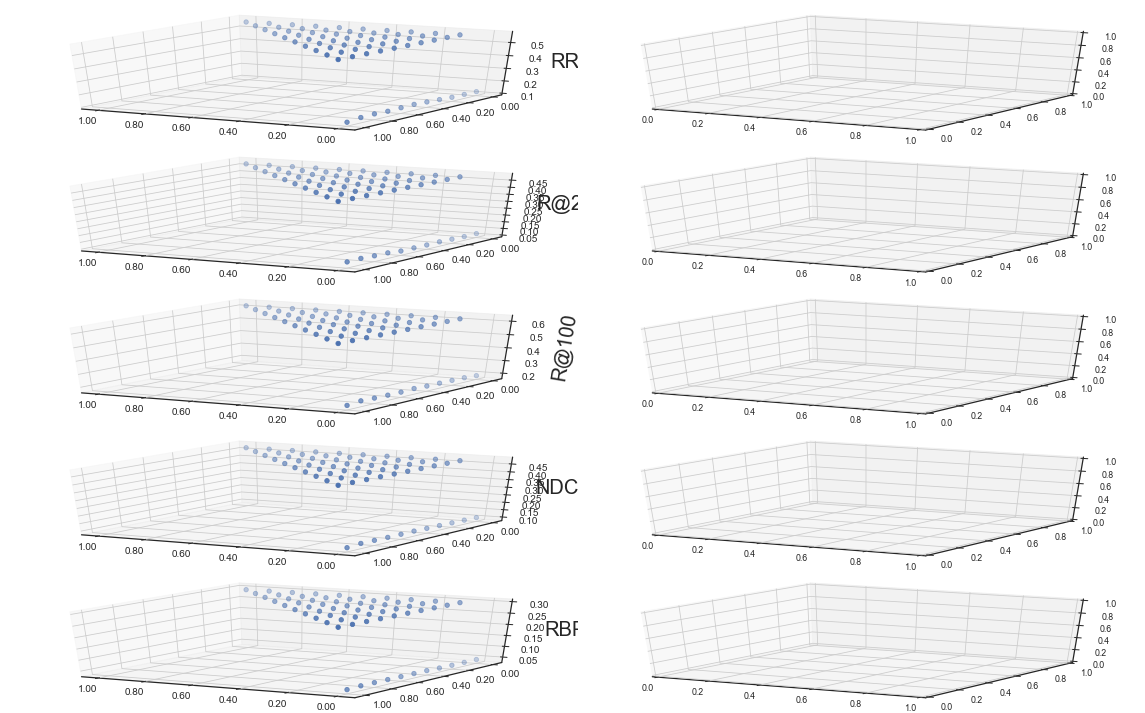

In [499]:
sdm_rerank_dfs = load_sdm(sdm_index, qrel_paths, '{0}-sdm-rerank-dir-mu-{1:.2f}-weights-{2:.2f}-{3:.2f}-{4:.2f}-window-{5}.run', os.path.join(BASE_DIR, sdm_path), sdm_dir_mu, 0.1, 2)
plot_sdm(sdm_rerank_dfs, display_names, metric_names)

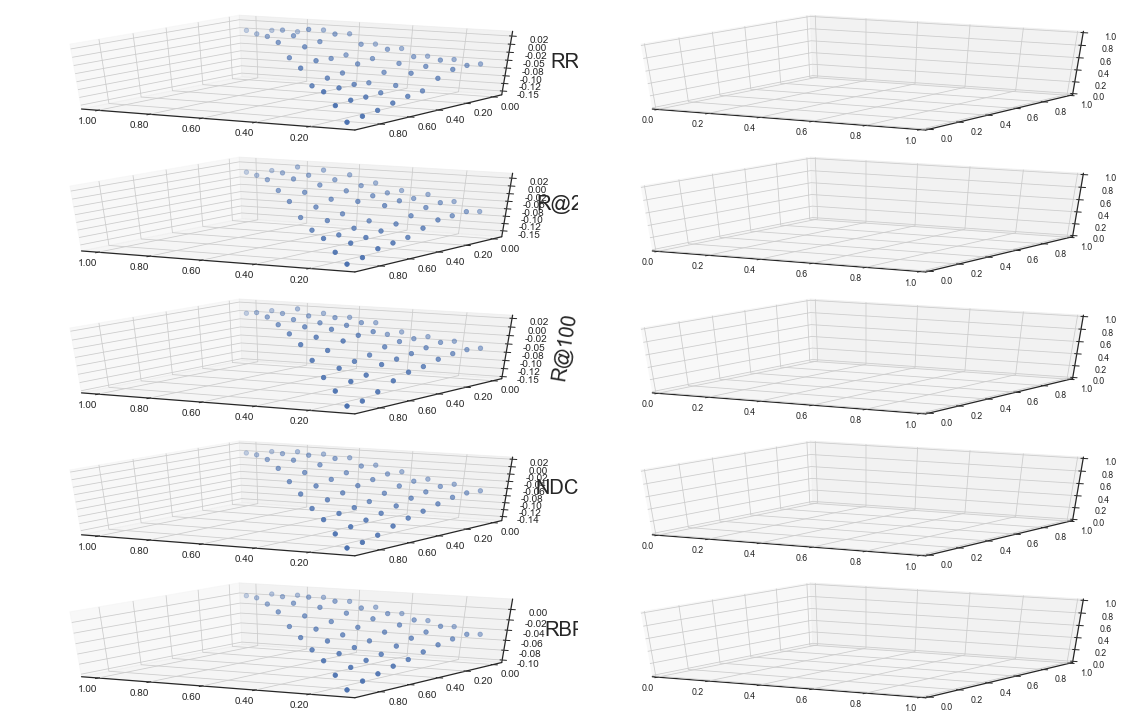

In [513]:
def plot_sdm_diff(dfs, rerank_dfs, index_names, metric_names):
    
    fig, axs = plt.subplots(len(metric_names), len(index_names), subplot_kw=dict(projection='3d'))
    fig.set_size_inches(16, 10)
    for i in range(len(index_names)):
#         print(dfs[i][0])
        xs = np.array([x[0][0] for x in dfs[i] if x[0][0] != 0])
        ys = np.array([x[0][1] for x in dfs[i] if x[0][0] != 0])
        
        cnt = 0 
        for j, m in enumerate(dfs[i][0][1].index):
            if m in metric_names:
                zs = np.array([x[1][m]-rerank_dfs[i][k][1][m] for k, x in enumerate(dfs[i]) if x[0][0] != 0])
                axs[cnt, i].scatter(xs, ys, zs)

                axs[cnt, i].tick_params(labelsize=10)
                axs[cnt, i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                axs[cnt, i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                axs[cnt, i].zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                
                if i == 0:
                    axs[cnt, i].set_zlabel(metric_names[m],fontsize=20)

                axs[cnt, i].view_init(30, 120)
                cnt += 1 

                
        break
            
    fig.tight_layout()
    
plot_sdm_diff(sdm_dfs, sdm_rerank_dfs, display_names, metric_names)

In [23]:
sdm_1d_dfs = load_1d_dfs(index_names[:1], qrel_paths, os.path.join(BASE_DIR, sdm_path), '{0}-sdm-dir-mu-2400.00-weights-0.80-0.10-0.10-window-{1}.run', rel_levels, 6, 21, 1)

IndexError: list index out of range

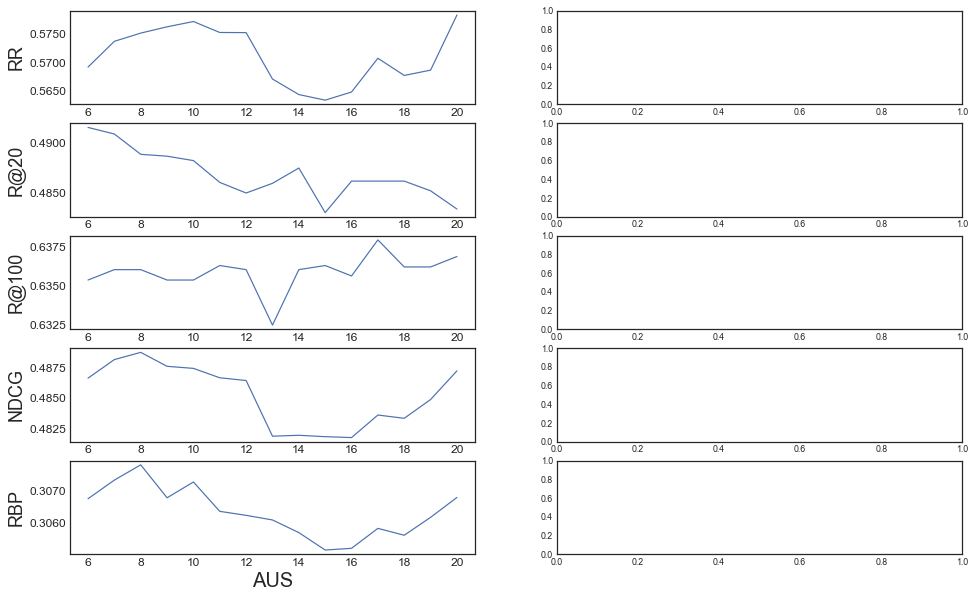

In [25]:
sdm_1d_fig = plot_tune_1d(display_names, metric_names, sdm_1d_dfs, 6, 21, 1)

# Comparing effectiveness to query length

In [44]:
import json 

def load_lengths(index_names, query_files):
    dfs = []
    for i, ind in enumerate(index_names):
        temp = {}
        with open(query_files[i]) as f:
            data = json.load(f)
            for t in data['topics']:
                temp[t['id']] = {'length': len(t['topic'].split())
                
        dfs.append(pd.DataFrame.from_dict(temp, orient='index'))
    
    return dfs 

query_files = ['/Users/danlocke/Desktop/case-topics.json', os.path.join(QREL_DIR, 'sigir', 'sigir-topic-topics.json')]

In [45]:
query_lengths = load_lengths(index_names, query_files)

In [89]:
def plot_tune_1d_len(index_names, param, metric_names, df, query_lens, start, end, increment): 
    fig, axs = plt.subplots(len(metric_names), len(index_names))
    fig.set_size_inches(16, 10)
    for i in range(len(index_names)):
        cnt = 0 
        for j, m in enumerate(df[i][0].columns):
            if m in metric_names:
                y = [(y[m]/query_lens[i]['length']).mean() for y in df[i]]
                axs[cnt, i].plot(np.arange(start, end, increment), y)

                if i == 0:
                    axs[cnt, i].set_ylabel(metric_names[m],fontsize=18)

                axs[cnt, i].tick_params(labelsize=12)
                axs[cnt, i].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
                cnt += 1

        axs[cnt-1, i].set_xlabel(index_names[i], fontsize=20)
        
    fig.tight_layout()
    return fig 

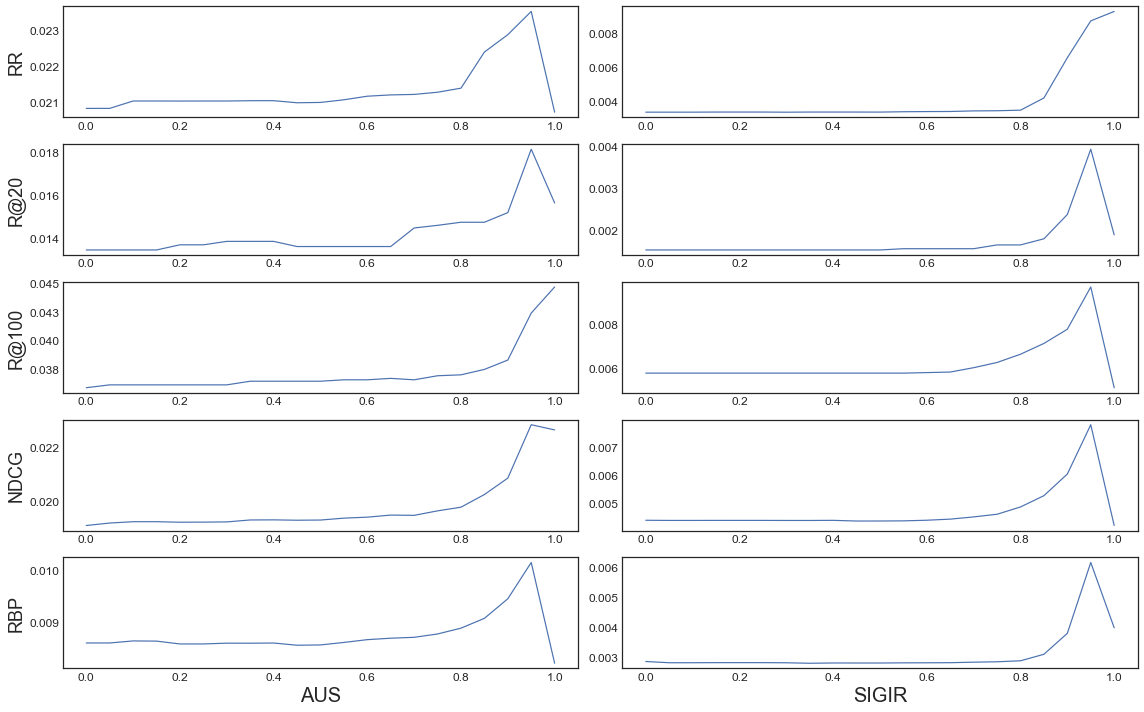

In [83]:
jm_query_dfs = load_1d_dfs(index_names, qrel_paths, os.path.join(BASE_DIR, jm_path), '{0}-unigram_jm_lambda_{1:.2f}.run', rel_levels, lambda_start, lambda_end, increment, True)
jm_fig = plot_tune_1d_len(display_names, "$\lambda$", metric_names, jm_query_dfs, query_lengths, lambda_start, lambda_end, increment)

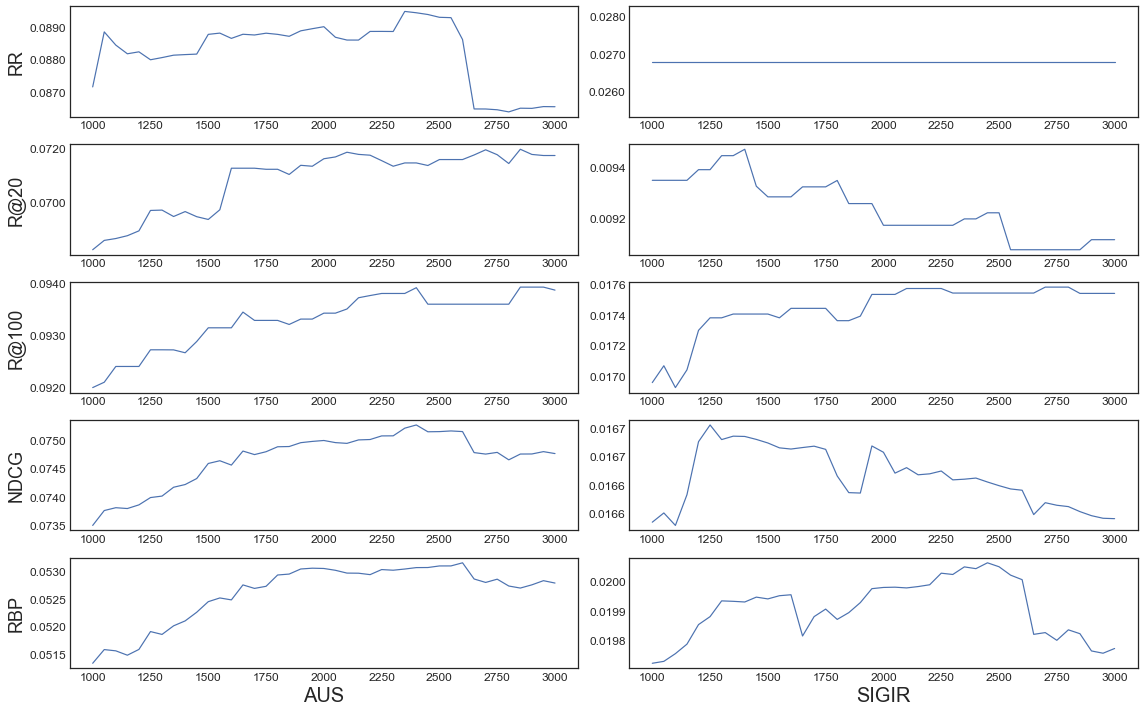

In [90]:
dir_query_dfs = load_1d_dfs(index_names, qrel_paths, os.path.join(BASE_DIR, dir_path), '{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, mu_start, mu_end, mu_increment, True)
dir_qry_len_fig = plot_tune_1d_len(display_names, "$\lambda$", metric_names, dir_query_dfs, query_lengths, mu_start, mu_end, mu_increment)

# stat sig

In [257]:
# do tfidf comparison 
tf_path = 'tfidf'

def generate_tf_tables(index_names, metrics=None, filtered=None):

    run_names = ['{0}-tf.run', '{0}-unigram_tfidf.run',  '{0}-tfidf-norm.run']
    names = ['TF', 'TF--IDF', 'TF--IDF-norm']

    for i, ind in enumerate(index_names): 
        files = []
        for j, r in enumerate(run_names):
            files.append((names[j], os.path.join(BASE_DIR, tf_path, r).format(ind), None))
            if filtered: 
                f_names = ['B', 'S']
                for f in range(len(f_names)):
                    files.append((names[j]+'-'+f_names[f], os.path.join(BASE_DIR, tf_path, r).format(ind), filtered[f]))    
                    
        if filtered:
            names = [x+y for x in names[1:] for y in ['', '-B', '-S']]
        else:
            names = names[1:]
        compute_stat_sig(files, os.path.join(QREL_DIR, 'aus', 'comb-aus.txt'), names, metrics, rel_levels[i])
    
generate_tf_tables(index_names[:1], metric_names, [broad, specific])

\begin{tabular}{llllll}
\toprule
{} &                                                 RR &                                               R@20 &                                              R@100 &                                               NDCG &                                                RBP \\
\midrule
TF             &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... \\
TF-B           &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... \\
TF-S           &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... &  0.0000$^{**,\Cross\Cross,\textdollar\textdolla... 

/Users/danlocke/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/danlocke/Library/Python/3.6/lib/python/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [349]:
ev_files = []
run_names = ['{0}-unigram_tfidf.run', '{0}-unigram_dir_mu_2400.00.run', '{0}-sdm-dir-mu-2400.00-weights-0.70-0.20-0.10-window-8.run', ]
run_dirs = ['tfidf', 'dirichlet_prior', 'sdm', 'bm25']
for i, r in enumerate(run_names):
    ev_files.append((run_dirs[i], os.path.join(BASE_DIR, run_dirs[i], r).format('flattened')))
    
print(ev_files)

compute_stat_sig(ev_files, os.path.join(QREL_DIR, 'aus', 'comb-aus.txt'), 'dirichlet_prior', '1')


[('tfidf', '/Users/danlocke/go/src/github.com/dan-locke/phd/experiments/tfidf/flattened-unigram_tfidf.run'), ('dirichlet_prior', '/Users/danlocke/go/src/github.com/dan-locke/phd/experiments/dirichlet_prior/flattened-unigram_dir_mu_2400.00.run'), ('sdm', '/Users/danlocke/go/src/github.com/dan-locke/phd/experiments/sdm/flattened-sdm-dir-mu-2400.00-weights-0.70-0.20-0.10-window-6.run')]
\begin{tabular}{ll}
\toprule
{} &    recip_rank \\
\midrule
tfidf           &  0.1765$^{*}$ \\
dirichlet_prior &   0.5520$^{}$ \\
sdm             &  0.4025$^{*}$ \\
\bottomrule
\end{tabular}



/Users/danlocke/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/danlocke/Library/Python/3.6/lib/python/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# PLM

In [36]:
sigma_start = 25
sigma_end = 300
sigma_inc = 25

plm_dfs = load_1d_dfs(index_names[:1], qrel_paths, os.path.join(BASE_DIR, 'plm'), 'case-topics-{0}-plm-dir-mu-2400.00-sigma-{1:.2f}.run', rel_levels, sigma_start, sigma_end, sigma_inc)
plm_b_dfs = load_1d_dfs(index_names[:1], qrel_paths, os.path.join(BASE_DIR, 'plm'), 'case-topics-{0}-plm-dir-mu-2400.00-sigma-{1:.2f}.run', rel_levels, sigma_start, sigma_end, sigma_inc, filtered=broad)
plm_s_dfs = load_1d_dfs(index_names[:1], qrel_paths, os.path.join(BASE_DIR, 'plm'), 'case-topics-{0}-plm-dir-mu-2400.00-sigma-{1:.2f}.run', rel_levels, sigma_start, sigma_end, sigma_inc, filtered=specific)

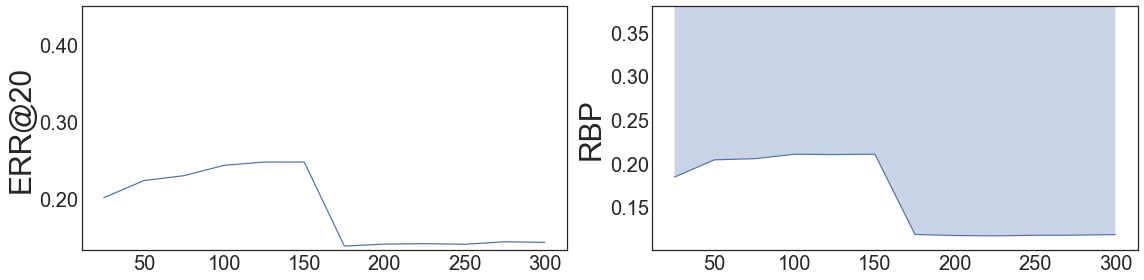

In [37]:
plm_fig = plot_single_orientation(display_names, RERANK_METRICS, plm_dfs, sigma_start, sigma_end, sigma_inc, ylims=YLIMS)
plm_fig.savefig('figures/plm-tuning.pdf')

In [ ]:
plm_bs_fig = plot_tune_1d_both(display_names, metric_names, plm_b_dfs, plm_s_dfs, 10, 50, 10)
plm_bs_fig.savefig('plm-bs-tuning.pdf')

In [ ]:
dir_bs_max = select_1d_max(['Broad', 'Specific'], metric_names, [dir_b_dfs[0], dir_s_dfs[0]], 300, mu_increment, "$\mu$", metric_names)